In [4]:
import wandb

!wandb login
wandb.init(project="GAN.ipynb")

wandb: Currently logged in as: tyrion279. Use `wandb login --relogin` to force relogin


In [6]:
# Using Torch Hub lib
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.utils as vutils
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import os
from PIL import Image

import matplotlib.pyplot as plt

In [7]:
# size of the latent space
latent_dim = 32

In [8]:
# 压缩后的图片尺寸，设置为64 * 64
SX = 64
SY = 64
N_CHANNELS = 1
EXTRINSIC_DIM = 6
LATENT_DIM = latent_dim

# 数据集的导入与处理
crop images by 128 x 128, downsize to 64 x 64

In [9]:
DATA_PATH = "./DATA/"
IMAGE_SUBPATH = "images"

df = pd.read_csv(os.path.join(DATA_PATH, "Dataset_descriptor.csv"), sep=",")

In [10]:
# shuffling dataframe
df = df.sample(frac=1).reset_index(drop=True)
df

,file name,sample id,position,temperature [C],Al-concentration [at.%],O-concentration [at.%],ionization degree [a.u.],average ion energy [eV],pressure [Pa],label
0,0001208_600-Pos3-50kx.jpg,1208,3,600,43.86000,10,0.500000,6.31924,0.5,facetted
1,4203_200_Pos06_50kx.jpg,4203,6,200,0.00000,3,1.000000,10.00000,0.5,facetted-oriented
2,0001208_600-Pos2-50kx.jpg,1208,2,600,49.36000,10,0.500000,6.69893,0.5,facetted
3,4203_500_Pos03_50kx.jpg,4203,3,500,0.00000,3,0.156250,4.60000,0.5,facetted
4,0001208_600-Pos8-50kx.jpg,1208,8,600,16.57000,10,0.500000,8.49609,0.5,facetted
...,...,...,...,...,...,...,...,...,...,...
118,1660-Pos4-50kx_ergebnis.jpg,1660,4,500,44.99311,0,1.000000,6.20415,0.5,facetted
119,1678-Pos9-50kx_ergebnis.jpg,1678,9,500,6.21288,0,1.200000,38.86007,1.0,facetted
120,4203_200_Pos05_50kx.jpg,4203,5,200,0.00000,3,0.357143,8.20000,0.5,facetted-oriented
121,1680-Pos3-50kx_ergebnis.jpg,1680,3,500,59.97647,0,1.000000,106.36527,0.5,featureless


In [11]:
df.columns

Index(['file name', 'sample id', 'position', 'temperature [C]',
       'Al-concentration [at.%]', 'O-concentration [at.%]',
       'ionization degree [a.u.]', 'average ion energy [eV]', 'pressure [Pa]',
       'label'],
      dtype='object')

In [12]:
Y_COLUMNS=['temperature [C]',
       'Al-concentration [at.%]', 'O-concentration [at.%]',
       'ionization degree [a.u.]', 'average ion energy [eV]', 'pressure [Pa]']

In [13]:
scaler = MinMaxScaler()

对information降维，观察其分布情况

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


temperature [C]


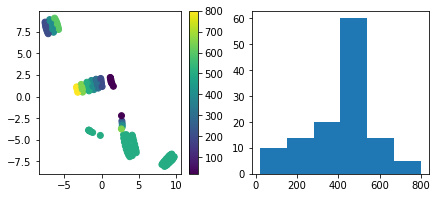

Al-concentration [at.%]


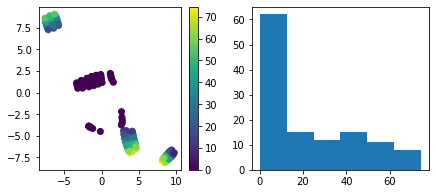

O-concentration [at.%]


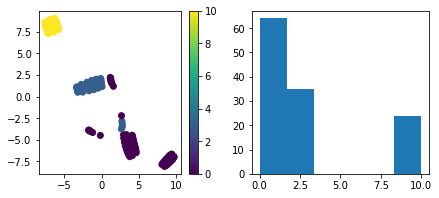

ionization degree [a.u.]


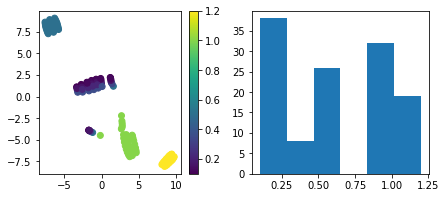

average ion energy [eV]


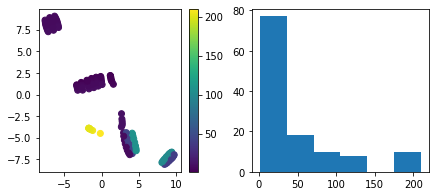

pressure [Pa]


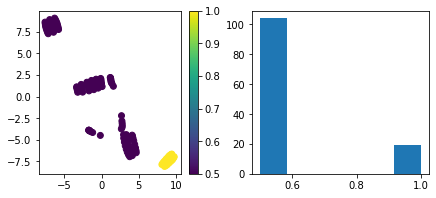

,temperature [C]_binning,Al-concentration [at.%]_binning,O-concentration [at.%]_binning,ionization degree [a.u.]_binning,average ion energy [eV]_binning,pressure [Pa]_binning,T
0,1,1,1,1,1,1,7
1,1,1,1,2,1,1,1
2,1,1,1,3,1,1,1
3,1,1,1,5,1,1,1
4,2,1,2,1,1,1,4
...,...,...,...,...,...,...,...
59,5,3,6,3,1,1,2
60,5,4,6,3,1,1,3
61,5,5,6,3,1,1,1
62,6,1,2,1,1,1,4


In [14]:
# 取我们需要用的值
y = df[Y_COLUMNS]
#做最大最小值归一化
y_scaled = scaler.fit_transform(y)
# 用tsne对标签进行降维, 默认是降到2维
tsne = TSNE(init='pca', learning_rate='auto')
y_tsne = tsne.fit_transform(y_scaled)

#number of bins per each extrinsic properties
BINS=6

for Y_column in Y_COLUMNS:
    print(Y_column)
    fig, axs= plt.subplots(1,2, figsize=(7,3))
    im=axs[0].scatter(y_tsne[:,0], y_tsne[:,1], c= df[Y_column])
    fig.colorbar(im, ax = axs[0])
    h=axs[1].hist(df[Y_column], bins=BINS)
    plt.show()

binning_labels_dict = {}
Y_COLUMNS_BINNING = []
for Y_column in Y_COLUMNS:
    # histogram means "直方图", bins是均匀分组后的边界
    cnt, bins = np.histogram(df[Y_column], bins=BINS)
    # 为什么要对这个减1？因为后面做searchsorted时，对这个边界的索引可能出问题
    bins[0] -= 1
    col_name = Y_column + "_binning"
    # 做这个操作是为了把所有的原始数据分成6组, 用1~6作为标签
    binning_labels_dict[col_name] = np.searchsorted(bins, df[Y_column].values)
    Y_COLUMNS_BINNING.append(col_name)

binning_df = pd.DataFrame(binning_labels_dict)
# 给其增加一列“T”，赋值全为1,用来计数，count之后T的值就是这种标签的个数
binning_df["T"] = 1
# 分别按照Y_COLUMNS_BINNING中的指标分组，统计每组的个数
# 这里按照这个列表去groupby,会自动列出所有可能的取值，然后再count，从而计算出每一类的数量，以及所有的类别，这个方法真的是特别巧妙
count_bins_df = binning_df.groupby(Y_COLUMNS_BINNING).count()
# 每个指标都有
# 这里补充一个reset_index的操作，原来的代码没有这个操作导致后面出问题了
count_bins_df = count_bins_df.reset_index()
count_bins_df

In [15]:
max_count=count_bins_df["T"].max()
# 与原始数据连接
df = pd.concat((df, binning_df), axis=1)
df.drop(labels="T", axis=1, inplace=True)
count_bins_df = count_bins_df.reset_index()

df=pd.merge(df,count_bins_df,on=Y_COLUMNS_BINNING)

df["weight"] = max_count/df["T"]

In [16]:
# 至此，csv数据处理完成
df

,file name,sample id,position,temperature [C],Al-concentration [at.%],O-concentration [at.%],ionization degree [a.u.],average ion energy [eV],pressure [Pa],label,temperature [C]_binning,Al-concentration [at.%]_binning,O-concentration [at.%]_binning,ionization degree [a.u.]_binning,average ion energy [eV]_binning,pressure [Pa]_binning,index,T,weight
0,0001208_600-Pos3-50kx.jpg,1208,3,600,43.86000,10,0.500000,6.31924,0.5,facetted,5,4,6,3,1,1,60,3,2.666667
1,0001208_600-Pos2-50kx.jpg,1208,2,600,49.36000,10,0.500000,6.69893,0.5,facetted,5,4,6,3,1,1,60,3,2.666667
2,0001208_600-Pos4-50kx.jpg,1208,4,600,38.38000,10,0.500000,6.13510,0.5,facetted,5,4,6,3,1,1,60,3,2.666667
3,4203_200_Pos06_50kx.jpg,4203,6,200,0.00000,3,1.000000,10.00000,0.5,facetted-oriented,2,1,2,5,1,1,6,1,8.000000
4,4203_500_Pos03_50kx.jpg,4203,3,500,0.00000,3,0.156250,4.60000,0.5,facetted,4,1,2,1,1,1,27,4,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,1680-Pos3-50kx_ergebnis.jpg,1680,3,500,59.97647,0,1.000000,106.36527,0.5,featureless,4,5,1,5,4,1,47,2,4.000000
119,0001208_600-Pos1-50kx.jpg,1208,1,600,54.85000,10,0.500000,7.14380,0.5,facetted,5,5,6,3,1,1,61,1,8.000000
120,4203_650_Pos06_50kx.jpg,4203,6,650,0.00000,3,1.000000,10.00000,0.5,facetted,5,1,2,5,1,1,57,1,8.000000
121,1660-Pos4-50kx_ergebnis.jpg,1660,4,500,44.99311,0,1.000000,6.20415,0.5,facetted,4,4,1,5,1,1,40,1,8.000000


In [17]:
# Image cropping & resizing 
BOX_SIZE = 128
BATCH_SIZE = 16
CROP_PER_IMAGE = 128

# ceil是向上取整
batch_count = int(np.ceil(len(df)/BATCH_SIZE))

YS = []
WEIGHTS = []
XS = []

for b in range(0, batch_count):
    print(b*BATCH_SIZE, "->", min(len(df), b*BATCH_SIZE+BATCH_SIZE)-1)
    batch_indices = np.arange(b*BATCH_SIZE,min(len(df),b*BATCH_SIZE+BATCH_SIZE))

    for ind in batch_indices:
        fname = df.loc[ind, "file name"]
        fname = os.path.join(DATA_PATH, IMAGE_SUBPATH, fname)
        im = Image.open(fname)
        for rep in range(CROP_PER_IMAGE):
            # 剪裁
            left = np.random.randint(0, im.width - BOX_SIZE)
            upper = np.random.randint(0, im.height - BOX_SIZE)

            box = left, upper, left+BOX_SIZE, upper+BOX_SIZE

            sub_image = im.crop(box)

            sub_image = sub_image.resize((SX, SY), resample=Image.Resampling.LANCZOS)

            sub_image_np = np.array(sub_image)
            sub_image_np = ((sub_image_np-127.5)/127.5).reshape(SX, SY, 1)
            # YS存储该图片对应的information
            YS.append(df.loc[ind, Y_COLUMNS].values)
            # WEIGHTS，存储这个图片的权重
            WEIGHTS.append(df.loc[ind, "weight"])
            # XS存储图片本身
            XS.append(sub_image_np)

        

0 -> 15
16 -> 31
32 -> 47
48 -> 63
64 -> 79
80 -> 95
96 -> 111
112 -> 122


In [18]:
YS = np.array(YS)
XS = np.array(XS)
WEIGHTS = np.array(WEIGHTS)

In [19]:
# 对标签信息做归一化
YS_scaled = scaler.fit_transform(YS)

array([0.74358974, 0.58850302, 1.        , 0.36363636, 0.02545091,
       0.        ])

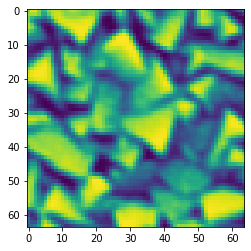

In [20]:
plt.imshow(XS[2,:,:,0])
YS_scaled[2]

In [21]:
XS = XS.reshape(-1, 1, 64, 64)
XS.shape

(15744, 1, 64, 64)

# 定义神经网络，准备机器学习

In [22]:
# Root directory for dataset
dataroot = DATA_PATH

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

label_dim = 6

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

wandb.config = {
    "learning_rate":lr,
    "epochs":num_epochs,
    "batch_size":batch_size
}

In [23]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

In [24]:
class GetData(Dataset):
    def __init__(self, datax, labely) -> None:
        self.data = torch.from_numpy(datax.astype(float)).to(device)
        self.label = torch.from_numpy(labely.astype(float)).to(device)
        self.len = len(datax)

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return self.len

dataset = GetData(XS, YS_scaled)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

torch.Size([128, 1, 64, 64])
tensor([0.6154, 0.0000, 0.0000, 0.2121, 0.9681, 0.0000], device='cuda:0',
       dtype=torch.float64)


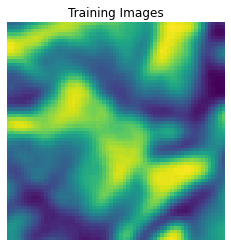

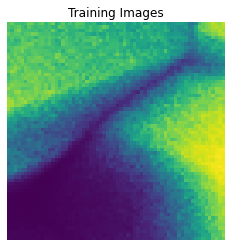

In [25]:
# Plot some training images
real_batch = next(iter(dataloader))
print(real_batch[0].size())
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(real_batch[0].cpu().numpy()[0, 0, :, :])
print(real_batch[1][0])
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(real_batch[0].cpu().numpy()[1, 0, :, :])
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

显示正常，说明我们的数据集读取无误

In [26]:
class Generator(nn.Module):
    r""" It is mainly based on the mobile net network as the backbone network generator.
    Args:
        image_size (int): The size of the image. (Default: 28)
        channels (int): The channels of the image. (Default: 1)
        num_classes (int): Number of classes for dataset. (Default: 10)
    """

    def __init__(self, image_size: int = 64, channels: int = 1, num_classes: int = label_dim) -> None:
        super(Generator, self).__init__()
        self.image_size = image_size
        self.channels = channels
        self.num_classes = num_classes
        # self.label_embedding = nn.Linear(num_classes, num_classes)
        # self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.ylabel = nn.Sequential(
            nn.Linear(num_classes, nz),
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            # 1*1*200 ->4*4*512 
            nn.ConvTranspose2d(nz + nz, 64*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),

            # 4*4*512 -> 8*8*256
            nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),

            # 8*8*256 -> 16*16*128
            nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),

            # 16*16*128 -> 32*32*64
            nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 32*32*64 -> 64*64*1
            nn.ConvTranspose2d( 64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, y):
        # 这一步似乎可以省略
        y=y.reshape(-1,self.num_classes)
        y = self.ylabel(y)
        y=y.reshape(-1,nz,1,1)
        x=x.reshape(-1,nz,1,1)
        out = torch.cat([x, y] , dim=1)
        out=out.view(-1,100+nz,1,1)

        out = self.main(out)
        
        return out

In [27]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, nc=1):
        super(Discriminator, self).__init__()
        
        self.ylabel=nn.Sequential(
            nn.Linear(label_dim, 64*64*1),
            nn.ReLU(True)
        )
        
        self.main = nn.Sequential(
            #input size nc +  1 che è la condizione
            nn.Conv2d(nc+1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64*2 , 64*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*4 , 64*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x, y):
        y = y.reshape(batch_size,label_dim)
        y = self.ylabel(y)
        y=y.view(-1, 1, image_size,image_size)
        out = torch.cat([x, y] , dim=1)
        out = self.main(out)

        return out

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.



In [28]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [29]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=EXTRINSIC_DIM):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.choice(len(YS),size=n_samples)
    weights = WEIGHTS[labels]
    labels=YS_scaled[labels]    
    return torch.from_numpy(z_input).to(device), torch.from_numpy(labels).to(device), weights

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input, weights_input = generate_latent_points(nz, n_samples)
    # predict outputs
    images = generator(z_input.float(), labels_input.float())
    # create class labels
    y = np.zeros((n_samples, 1))
    return images, labels_input, y

In [30]:
def train_GAN(G, D, G_opt, D_opt, dataset):
    for i,(data,label) in tqdm(enumerate(dataset)):

        '''
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(data, padding=2).cpu(),(1,2,0)))
        plt.show()
        '''
    
        ## Train with all-real batch        
        D_opt.zero_grad()

        # 真实数据 
        x_real = data.to(device).float()
        y_real = torch.ones(batch_size, ).to(device)
        # label_onehot = onehot[label]
        label = label.to(device).float()
        y_real_predict = D(x_real, label).squeeze()      
        d_real_loss = criterion(y_real_predict, y_real)
        wandb.log({'d_real_loss':d_real_loss})
        d_real_loss.backward()

        ## Train with all-fake batch

        # noise = torch.randn(batch_size, nz, 1, 1, device = device)
        # noise_label = (torch.rand(batch_size, 1) * label_dim).type(torch.LongTensor).squeeze()
        #print(noise_label)
        # noise_label_onehot = onehot[noise_label].to(device)  # Genera label in modo casuale (-1,)
        # x_fake = G(noise, noise_label_onehot)       #Genera immagini false
        # y_fake = torch.zeros(batch_size, ).to(device)    # Assegna label 0
        # y_fake_predict = D(x_fake, noise_label_onehot).squeeze()

        # 生成fake数据
        x_fake, noise_label, y_fake= generate_fake_samples(G, label_dim, batch_size)
        y_fake_predict = D(x_fake.float(), noise_label.float()).squeeze()
        y_fake = torch.from_numpy(y_fake).reshape(-1).float().to(device)
        d_fake_loss = criterion(y_fake_predict, y_fake)
        wandb.log({'d_fake_loss':d_fake_loss})
        d_fake_loss.backward()
        D_opt.step()
         
        # (2) Update G network: maximize log(D(G(z)))         
        G_opt.zero_grad()
         
        #noise = torch.randn(batch_size, z_dim, 1, 1, device = device)
        #noise_label = (torch.rand(batch_size, 1) * label_dim).type(torch.LongTensor).squeeze()
        #noise_label_onehot = onehot[noise_label].to(device)   # Genera label in modo casuale (-1,)
        # x_fake = G(noise, noise_label_onehot)
        x_fake, noise_label, y_fake= generate_fake_samples(G, label_dim, batch_size)
        y_fake = torch.ones(batch_size, ).to(device)    # Il y_fake qui è lo stesso di y_real sopra, entrambi sono 1
        y_fake_predict = D(x_fake.float(), noise_label.float()).squeeze()
        g_loss = criterion(y_fake_predict, y_real)    # Usa direttamente y_real per essere più intuitivo
        wandb.log({'g_loss':g_loss})
        g_loss.backward()
        G_opt.step()

        err_D = d_fake_loss.item() + d_real_loss.item()
        err_G = g_loss.item()
        wandb.log({'err_D':err_D, 'err_G':err_G})
        '''
        if i%50 == 0:
            with torch.no_grad():
                out_imgs = G(fixed_noise.to(device), fixed_label.to(device))
            save_image(out_imgs,f"{PATH}{i}.png", nrow = 10) #aggiungi percorso: "path/iterazione_classe.png" es "pippo/20000_3.png"
        '''
    return err_D, err_G


In [31]:
# Models
D = Discriminator().cuda()
D.apply(weights_init)

G = Generator().cuda()
G.apply(weights_init)

D_opt = torch.optim.Adam(D.parameters(), lr= lr, betas=(beta1, 0.999))#, betas=(beta1, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr= lr, betas=(beta1, 0.999))#, betas=(beta1, 0.999))

print(next(D.parameters()).device)

cuda:0


In [32]:
# Loss function
criterion = torch.nn.BCELoss()

In [33]:
fixed_noise = torch.randn(100,100)
fixed_noise = fixed_noise.reshape(100,100,1,1)

In [34]:
D_loss = []
G_loss = []

  0%|          | 0/30 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

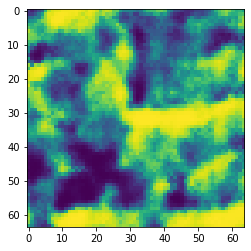

In [35]:
for epoch in tqdm(range(num_epochs)):
    D_losses = []
    G_losses = []
    if epoch == 5 or epoch == 10:
        G_opt.param_groups[0]['lr'] /= 2
        D_opt.param_groups[0]['lr'] /= 2
        
    # training
    err_D, err_G = train_GAN(G, D, G_opt, D_opt, dataloader)

    D_loss.append(err_D)
    G_loss.append(err_G)

    with torch.no_grad():
        x_fake, noise_label, y_fake= generate_fake_samples(G, label_dim, 1)

    plt.imshow(x_fake[0, 0, :, :].cpu())

In [36]:
y = [4.0, 1.0, 1.0, 1.0, 6.0, 1.0]
y = torch.tensor(y).to(device)
y

tensor([4., 1., 1., 1., 6., 1.], device='cuda:0')

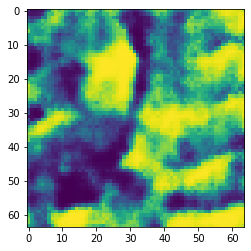

In [57]:
x = torch.randn(1,100).to(device)
# y = YS_scaled[100].astype(float)

y = YS_scaled[100]
y = torch.from_numpy(y).float().to(device)
with torch.no_grad():
    out = G(x, y)
    
plt.imshow(out.cpu()[0, 0, :, :])


[0.74358974 0.58850302 1.         0.36363636 0.02545091 0.        ]


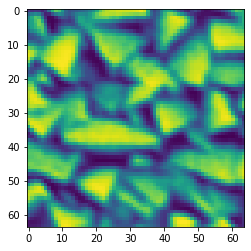

In [44]:
plt.imshow(XS[100, 0, :, :])
print(YS_scaled[100])

In [58]:
wandb.finish()

d_fake_loss,▁▆▃▅▄▁▅▅▄█▆▂▄▃▂▃▂▂▄▃▂▂▂▂▂▂▂▂▂▅▂▃▃▂▁▃▄▂▂▂
d_real_loss,▂▂▁▂▂█▁▃▂▂▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
err_D,▂▃▂▃▃█▂▄▂▄▃▂▂▂▂▂▁▁▂▂▁▂▁▁▁▂▁▁▂▂▂▁▁▁▁▁▂▁▁▁
err_G,█▄▂▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▂▂▁▁▂▁▁▁▂▂▂▂▁▂▂▂▂▂▃▂▂▂
g_loss,█▄▂▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▂▂▁▁▂▁▁▁▂▂▂▂▁▂▂▂▂▂▃▂▂▂
d_fake_loss,0.04779
d_real_loss,0.07284
err_D,0.12063
err_G,5.10332
g_loss,5.10332


In [36]:
D_loss

[0.12142239511013031,
 0.3271980881690979,
 0.5759727656841278,
 0.46188077330589294,
 1.5468824319541454,
 0.4366215467453003,
 0.6157943308353424,
 0.40881888568401337,
 0.15743345022201538,
 0.220895916223526,
 0.2358802855014801,
 0.20020819455385208,
 0.11447612941265106,
 0.13306798785924911,
 0.15082327648997307,
 0.23894052952528,
 0.1372642107307911,
 0.1911938562989235,
 0.14383121207356453,
 0.2717171534895897,
 0.1967087835073471,
 0.07299825921654701,
 0.1874053031206131,
 0.0715455636382103,
 0.229144137352705,
 0.03538905177265406,
 0.07453255262225866,
 0.32021285966038704,
 0.16992069873958826,
 0.13819700479507446]

In [37]:
G_loss

[5.882569313049316,
 5.452925205230713,
 6.061920166015625,
 4.0240888595581055,
 5.975322723388672,
 2.7585220336914062,
 2.9824748039245605,
 2.805396556854248,
 4.8581647872924805,
 5.099690914154053,
 4.014743328094482,
 3.6379542350769043,
 3.825599193572998,
 4.5139007568359375,
 4.256728649139404,
 3.9896388053894043,
 4.497465133666992,
 4.809916019439697,
 5.465537071228027,
 4.889987945556641,
 4.597760200500488,
 4.561806678771973,
 4.889675617218018,
 5.971559524536133,
 6.1884050369262695,
 5.0011796951293945,
 6.793827056884766,
 3.3042354583740234,
 3.6979146003723145,
 4.30507755279541]